# Feature Engineering

This notebook create new features and mesures the the perfomance change in the model. The goal is to create features to increase the model performance.

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [2]:
# Read the data to a pandas data frame
df = pd.read_csv('original_apartment_data_analytics_hs24_with_lat_lon.csv', sep=',', encoding='utf-8')
# Get number of rows and columns
df.shape

(819, 18)

In [3]:
df.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y'],
      dtype='str')

## Model Performance

In [4]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [5]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [ -964.  -746.  -775. -1109.  -880.]
Mean RMSE: -894.8


## Data Cleaning
- Remove apartments with empty columns
- Remove apartments which price exceeds 6000.-
- Remove apartments which price is lower than 1000.-

In [6]:
print('Total apartment before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 750) & 
            (df['price'] <= 8000)]

print('Total apartment after data cleaning:', len(df))

Total apartment before data cleaning: 819
Total apartment after data cleaning: 804


In [7]:
# Before data cleaning Mean RMSE: -894.8

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [-616. -788. -680. -705. -727.]
Mean RMSE: -703.2


## Feature engineering

### Create additional variables from the apartment's descriptions

In [8]:
# Create the new variable
df['room_per_m2'] = round(df['area'] / df['rooms'], 2)
df['price_per_m2'] = round(df['price'] / df['area'], 2)

In [9]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2']
model_performance(features, df)

CV results RMSE: [-621. -760. -637. -688. -715.]
Mean RMSE: -684.2


In [10]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'price_per_m2']
model_performance(features, df)

CV results RMSE: [-189. -267. -293. -216. -201.]
Mean RMSE: -233.2


<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Question:</strong>Why is the performance, nearly perfect, when using the feature 'price_per_m2'?
</div>
<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Answer:</strong> <span style="background-color: black; color: black;" onmouseover="this.style.color='white'" onmouseout="this.style.color='black'">The feature 'price_per_m2' represents the price per square meter, which is the target variable we aim to predict. If you know both the area and 'price_per_m2', calculating the total price becomes straightforward.</span>
</div>

#### Create new binary (0/1) variable 'luxurious'

In [11]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(LOFT)|(SEESICHT)|(ATTIKA)|(LUXURIÖS)|(LUXU)|(POOL)|(EXKLUSIV)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['luxurious'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Luxurious Apartments', df['luxurious'].sum())

Total of Luxurious Apartments 5


#### Create new binary (0/1) variable 'temporary'

In [12]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(TEMPOR)|(BEFRIST)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['temporary'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Temporary Apartments', df['temporary'].sum())

Total of Temporary Apartments 16


#### Create new binary (0/1) variable 'furnished'

In [13]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(FURNISHED)|(MÖBLIERT)|(FURNISHE)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['furnished'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Furnished Apartments', df['furnished'].sum())

Total of Furnished Apartments 15


In [14]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished']
model_performance(features, df)

CV results RMSE: [-627. -745. -631. -780. -695.]
Mean RMSE: -695.6


#### Create new categorical variable based on apartment area

In [15]:
labels = ['0 - 49', '50 - 99', '100 - 500']
df["area_cat"] = pd.cut(df.area, bins=[0, 50, 100, 500], labels=labels)
df[['area', 'area_cat']].head(10)

,area,area_cat
0,49,0 - 49
1,111,100 - 500
2,58,50 - 99
3,118,100 - 500
4,66,50 - 99
5,61,50 - 99
6,65,50 - 99
7,101,100 - 500
8,68,50 - 99
9,191,100 - 500


In [16]:
from sklearn.preprocessing import OrdinalEncoder

area_cat = df['area_cat'].values.reshape(-1,1)
ordinal_encoding = OrdinalEncoder()
area_cat_encoded = ordinal_encoding.fit_transform(area_cat) 

df['area_cat_ecoded'] = area_cat_encoded


In [17]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded']
model_performance(features, df)

CV results RMSE: [-627. -746. -630. -783. -702.]
Mean RMSE: -697.6


### Luxurious One Hot Encoding
One-Hot Encoding is a technique used in machine learning to convert categorical variables into a binary (0/1) format. Each unique category is represented as a separate column, and a 1 is assigned if that category is present, otherwise, it's 0.

Example:

| description_raw                                         | (ATTIKA) | (EXKLUSIV) | (LOFT) | (LUXURIÖS) | (POOL) | (SEESICHT) | (NONE) |
|---------------------------------------------------------|----------|------------|--------|------------|--------|------------|--------|
| Dieses Apartment ist sehr LUXURIÖS mit POOL.           | 0        | 0          | 0      | 1          | 1      | 0          | 0      |
| Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.    | 0        | 1          | 1      | 0          | 0      | 1          | 0      |
| Normale Wohnung ohne Extras.                           | 0        | 0          | 0      | 0          | 0      | 0          | 1      |
| Schöne Aussicht, aber keine besonderen Merkmale.       | 0        | 0          | 0      | 0          | 0      | 0          | 1      |


In [18]:
# If you want to test one hot encoding with multiple categories
#df.loc[0, "description_raw"] = 'Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.'
#df.iloc[0].description_raw

In [19]:
# Define terms for encoding
terms = {'(ATTIKA)', '(EXKLUSIV)', '(LOFT)', '(LUXURIÖS)', '(POOL)', '(SEESICHT)'}

# Create one-hot encoded columns
for term in terms:
    df[term] = df['description_raw'].str.contains(term.strip("()"), case=False, na=False).astype(int)


In [20]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)']
model_performance(features, df)

CV results RMSE: [-623. -730. -619. -780. -677.]
Mean RMSE: -685.8


### Split Zurich into Kreis

<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Note:</strong>To obtain the latitude and longitude, please refer to the slides attachment. We haven't included them here because they are extracted from an API, and if every student attempts to retrieve them, the API may not respond well. 😉
</div>

In [21]:
bfs_number_counts = df.groupby(['bfs_number', 'town']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(bfs_number_counts)

     bfs_number                  town  counts
111         261                Zürich     262
99          230            Winterthur      96
56          121           Wetzikon ZH      20
86          198                 Uster      18
15           53                Bülach      15
..          ...                   ...     ...
84          196           Mönchaltorf       1
26           66   Glattpark (Opfikon)       1
24           64            Nürensdorf       1
87          199             Gutenswil       1
115         298          Wiesendangen       1

[116 rows x 3 columns]


In [23]:
from shapely.geometry import Point
import geopandas as gpd

# Convert lat/lon to Shapely Points
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Load GeoDataFrame with polygons of the city of Zurich
gdf = gpd.read_file('stzh.adm_stadtkreise_a.json')

# Initialize one-hot encoding columns with 0s
for name in gdf['bezeichnung']:
    df[name] = 0  

# Iterate through each polygon and check if the points are inside
for _, row in gdf.iterrows():
    polygon_name = row['bezeichnung']
    polygon_geom = row['geometry']
    
    # Check if each point is inside the polygon and update the corresponding column
    df[polygon_name] = df['geometry'].apply(lambda point: 1 if polygon_geom.contains(point) else 0)

# Drop the geometry column (optional)
df.drop(columns=['geometry'], inplace=True)
df.head()

,bfs_number,rooms,area,price,postalcode,address,town,description_raw,bfs_name,pop,...,Kreis 12,Kreis 10,Kreis 4,Kreis 1,Kreis 9,Kreis 5,Kreis 7,Kreis 3,Kreis 2,Kreis 8
0,118,3.0,49,1441,8630,"Neuhusstrasse 6, 8630 Rüti ZH",Rüti ZH,«Gemütliche Wohnung im Grünen»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
1,118,3.0,111,2600,8630,"Widacherstrasse 5, 8630 Rüti ZH",Rüti ZH,«3 Zimmer-Maisonette-Wohnung»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
2,118,3.0,58,1490,8630,"Widenweg 14, 8630 Rüti ZH",Rüti ZH,"«Ruhig & Grün , Genau was Sie suchen !»",Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
3,118,4.0,118,3240,8630,"Rain 1, 8630 Rüti ZH",Rüti ZH,«Gemütliches 4-Zimmer-Reihenhaus in zentraler ...,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
4,118,3.0,66,1450,8630,"Bachtelstrasse 24b, 8630 Rüti ZH",Rüti ZH,«Schöne 3-Zimmerwohnung in ruhigem Quartier»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df[df.bfs_number == 261][['town', 'address', "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"]].head(10)

,town,address,Kreis 1,Kreis 2,Kreis 3,Kreis 4,Kreis 5,Kreis 6,Kreis 7,Kreis 8,Kreis 9,Kreis 10,Kreis 11,Kreis 12
10,Zürich,"Cramerstrasse 8-12, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
11,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
12,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
13,Zürich,"Hildastrasse 1, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
14,Zürich,"Badenerstrasse 123, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
15,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
17,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
18,Zürich,"Dienerstrasse 59, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
19,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
20,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-592. -680. -581. -770. -666.]
Mean RMSE: -657.8


### Fix pop_dens and pop of city of zurich

In [26]:
# Creating the DataFrame with pop and pop_dens for each Kreis
data = {
    "ID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Kreis": [
        "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"
    ],
    "pop": [5890, 37639, 50950, 29944, 15874, 35688, 39647, 17860, 59841, 41411, 78801, 33537],
    "pop_dens": [3232, 3254, 5792, 10008, 7942, 6932, 2574, 3704, 4729, 4512, 5736, 5470]
}

zuerich_pop_dens = pd.DataFrame(data)
zuerich_pop_dens

,ID,Kreis,pop,pop_dens
0,1,Kreis 1,5890,3232
1,2,Kreis 2,37639,3254
2,3,Kreis 3,50950,5792
3,4,Kreis 4,29944,10008
4,5,Kreis 5,15874,7942
5,6,Kreis 6,35688,6932
6,7,Kreis 7,39647,2574
7,8,Kreis 8,17860,3704
8,9,Kreis 9,59841,4729
9,10,Kreis 10,41411,4512


In [27]:
#Applying pop and pop_dens to df of Zurich
kreis_columns = ['Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10', 'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3', 'Kreis 2', 'Kreis 8']

for kreis_nr in kreis_columns:
    df.loc[df[kreis_nr] == 1, 'pop'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop'].values[0]
    df.loc[df[kreis_nr] == 1, 'pop_dens'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop_dens'].values[0]

In [28]:
df[df.bfs_number==261].pop_dens

10     10008.0
11     10008.0
12     10008.0
13     10008.0
14     10008.0
        ...   
280     5792.0
281     5792.0
282     5792.0
283     5792.0
284     4729.0
Name: pop_dens, Length: 266, dtype: float64

In [29]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-590. -663. -580. -759. -680.]
Mean RMSE: -654.4


In [30]:
df['zurich_city'] = 0
df.loc[df[kreis_columns].any(axis=1), 'zurich_city'] = 1

In [31]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-593. -659. -582. -759. -670.]
Mean RMSE: -652.6


<Axes: ylabel='features'>

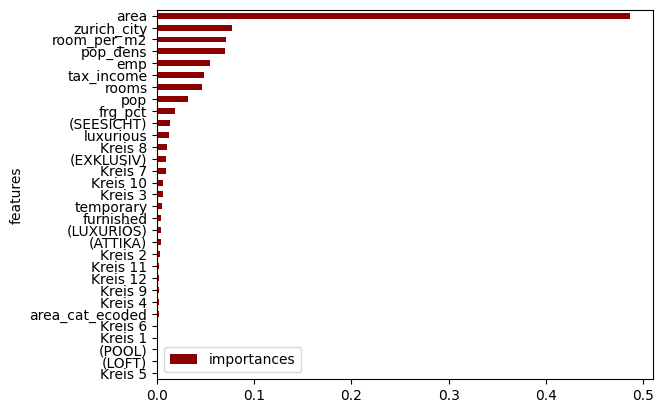

In [32]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

In [33]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-582. -670. -600. -756. -679.]
Mean RMSE: -657.4


<Axes: ylabel='features'>

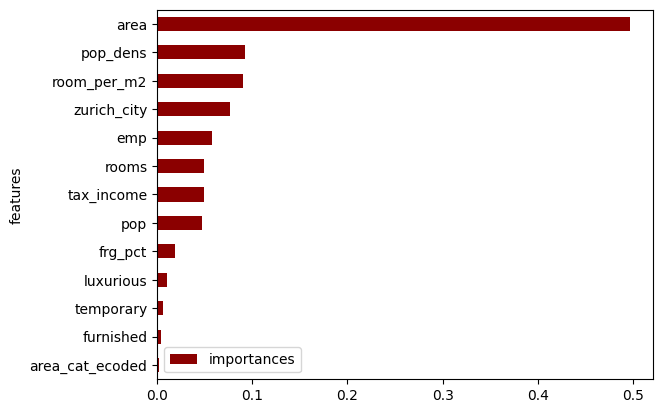

In [34]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

### Error analysis

In [35]:
# get all predictions for the training set.

# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

price_prediction = random_forest_model.predict(df[features])
df_with_residual = pd.DataFrame(df[features], columns=df[features].columns, copy=True)
df_with_residual['recidual (error)'] = np.abs(price_prediction - df.price)
df_with_residual['price'] = df.price
df_with_residual['predicted_price'] = price_prediction
print(df_with_residual.head())
# Add text, postalcode and town name
# we use join instead of merge, because we 'join' on the index column and do not perform a merge using a specific column
df_with_residual = df_with_residual.join(df[['description_raw', 'bfs_name', 'postalcode', 'town']])

   rooms  area    pop     pop_dens    frg_pct     emp  tax_income  \
0    3.0    49  12286  1221.272366  24.841283  5053.0       66676   
1    3.0   111  12286  1221.272366  24.841283  5053.0       66676   
2    3.0    58  12286  1221.272366  24.841283  5053.0       66676   
3    4.0   118  12286  1221.272366  24.841283  5053.0       66676   
4    3.0    66  12286  1221.272366  24.841283  5053.0       66676   

   room_per_m2  luxurious  temporary  furnished  area_cat_ecoded  zurich_city  \
0        16.33          0          0          0              0.0            0   
1        37.00          0          0          0              1.0            0   
2        19.33          0          0          0              2.0            0   
3        29.50          0          0          0              1.0            0   
4        22.00          0          0          0              2.0            0   

   recidual (error)  price  predicted_price  
0         36.450000   1441      1477.450000  
1     

In [36]:
# check which location has the largest errors.
df_with_residual[(df_with_residual['recidual (error)'] > 500)].groupby(['pop', 'bfs_name']).size().sort_values(ascending=False)

pop     bfs_name     
39647   Zürich           6
50950   Zürich           5
41411   Zürich           5
37639   Zürich           4
113173  Winterthur       4
17860   Zürich           3
29944   Zürich           3
78801   Zürich           2
59841   Zürich           2
16841   Wallisellen      2
4840    Oetwil am See    1
33537   Zürich           1
35007   Uster            1
5890    Zürich           1
18139   Thalwil          1
15874   Zürich           1
13067   Zollikon         1
7228    Oberglatt        1
6485    Fehraltorf       1
420217  Zürich           1
dtype: int64

In [37]:

df_with_residual[(df_with_residual['recidual (error)'] > 800)].to_csv('data_with_large_residuals.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

## Find the best parameters
- GridSearch
- RandomSearchCV

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 500, 1000]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3,
scoring='neg_root_mean_squared_error', verbose = 2)
grid_search.fit(df[features], df.price)

# get best estimator:
grid_search.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=500; total time=   0.8s
[CV] END ...................................n_estimators=500; total time=   0.7s
[CV] END ...................................n_estimators=500; total time=   0.6s
[CV] END ..................................n_estimators=1000; total time=   1.6s
[CV] END ..................................n_estimators=1000; total time=   1.4s
[CV] END ..................................n_estimators=1000; total time=   1.4s


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [39]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

print('After GridSearch')
model_performance(features, df, RandomForestRegressor(n_estimators=1000, random_state=42))



CV results RMSE: [-582. -670. -600. -756. -679.]
Mean RMSE: -657.4
After GridSearch
CV results RMSE: [-587. -670. -598. -757. -672.]
Mean RMSE: -656.8


In [40]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_depth': [90, 100, 110],
'max_features': [6, 9],
'min_samples_leaf': [4, 5],
'min_samples_split': [10, 12],
'n_estimators': [100, 500, 1000]
}

clf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, random_state=0, n_iter=10, verbose=2)
search = clf.fit(df[features], df.price)

print(search.best_estimator_)
model_performance(features, df, search.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; t

In [41]:
df.to_csv('apartments_data_enriched_with_new_features.csv')